In [2]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd

from functools import partial
from mpl_lego.labels import bold_text
from pyprojroot import here
from scipy.stats import bootstrap

from normative_evaluation_llms_everyday_dilemmas import keys
 
%matplotlib inline

In [ ]:
# Turn into LaTeX style; you need to have LaTeX installed
mplego.style.use_latex_style()

In [4]:
df = pd.read_csv(here('data/normative_evaluation_everyday_dilemmas_dataset.csv'))

In [5]:
# Calculate bootstrap estimates
def categorical_proportion(data, category):
    return np.mean(data == category)

In [6]:
# For reporting exact values of label distributions
for idx, label_col in enumerate(keys.LABEL_COLS):
    proportions = df[label_col].value_counts(normalize=True)
    print("Model:", label_col)
    print(proportions)
    print('----')

Model: reddit_label
reddit_label
NTA    0.764179
YTA    0.170238
INF    0.023924
NAH    0.020968
ESH    0.020691
Name: proportion, dtype: float64
----
Model: gpt3.5_label_1
gpt3.5_label_1
NTA    0.553021
YTA    0.312950
ESH    0.105302
INF    0.023924
NAH    0.004803
Name: proportion, dtype: float64
----
Model: gpt4_label_1
gpt4_label_1
NTA    0.750416
YTA    0.127286
NAH    0.064567
ESH    0.057177
INF    0.000554
Name: proportion, dtype: float64
----
Model: claude_label_1
claude_label_1
NTA    0.868650
YTA    0.082856
ESH    0.034824
NAH    0.013209
INF    0.000462
Name: proportion, dtype: float64
----
Model: bison_label_1
bison_label_1
NTA    0.880658
YTA    0.072695
NAH    0.027157
ESH    0.017827
INF    0.001663
Name: proportion, dtype: float64
----
Model: llama_label_1
llama_label_1
YTA    0.792721
NAH    0.151487
ESH    0.050711
NTA    0.005080
Name: proportion, dtype: float64
----
Model: mistral_label_1
mistral_label_1
NAH    0.393682
ESH    0.355348
INF    0.113338
NTA    0.07

In [7]:
# Calculate bounds for bootstrap estimates on label distributions
observed_bounds = [[
    bootstrap((df[label_col].values,), partial(categorical_proportion, category=label))
    for label in keys.AITA_LABELS]
    for label_col in keys.LABEL_COLS]

/opt/homebrew/Caskroom/miniforge/base/envs/llm/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/llm/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


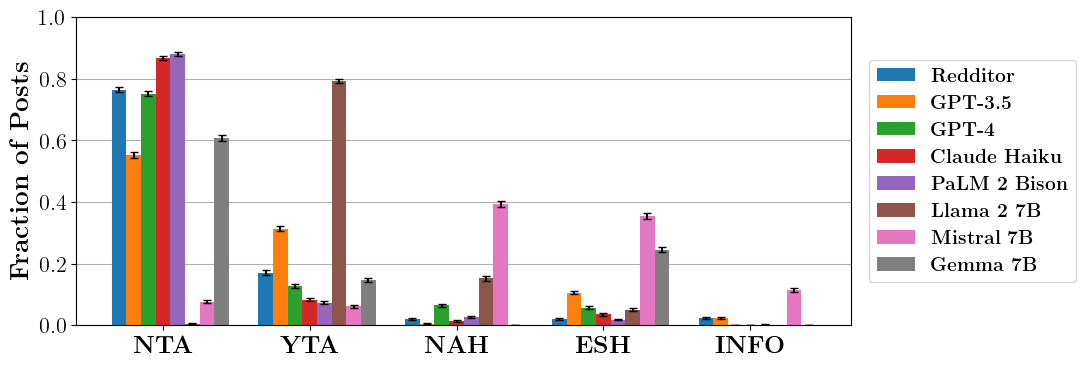

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

BAR_WIDTH = 0.10
X_AXIS_TICK_FONTSIZE = 18
Y_AXIS_TICK_FONTSIZE = 16
Y_AXIS_LABEL_FONTSIZE = 19
ERROR_BAR_CAPSIZE = 3
LEGEND_SIZE = 14

# Iterate over model labels
for idx, reason_col in enumerate(keys.LABEL_COLS):
    # Calculate proportions
    proportions = df[reason_col].value_counts(normalize=True)
    # Fill in missing AITA labels
    for label in keys.AITA_LABELS:
        if label not in proportions:
            proportions[label] = 0
    # Sort AITA labels
    proportions = proportions.loc[keys.AITA_LABELS]

    # Plot fraction of posts for each AITA label
    ax.bar(
        x=np.arange(keys.n_aita_labels) + idx * BAR_WIDTH,
        height=proportions,
        width=BAR_WIDTH,
        color=f'C{idx}',
        # Bootstrapped error bars
        yerr=[[observed_bounds[idx][ii].confidence_interval.high - proportions.loc[aita_label]
               for ii, aita_label in enumerate(keys.AITA_LABELS)],
              [proportions[aita_label] - observed_bounds[idx][ii].confidence_interval.low
               for ii, aita_label in enumerate(keys.AITA_LABELS)]],
        error_kw={'capsize': ERROR_BAR_CAPSIZE})

# Set up legend with dummy bars
for idx, label in enumerate(keys.MODEL_LABELS_PLOT):
    ax.bar(x=0.5,
           height=0,
           color=f'C{idx}',
           label=bold_text(label))

# Create legend
ax.legend(loc='center left',
          bbox_to_anchor=(1.01, 0.5),
          prop={'size': LEGEND_SIZE})

# x-axis
ax.set_xticks(np.arange(keys.n_aita_labels) + 3 * BAR_WIDTH)
ax.set_xticklabels(bold_text(keys.AITA_LABELS_PLOT), fontsize=X_AXIS_TICK_FONTSIZE)

# y-axis
ax.tick_params(axis='y', labelsize=Y_AXIS_TICK_FONTSIZE)
ax.set_ylim([0, 1])
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_ylabel(bold_text('Fraction of Posts'), fontsize=Y_AXIS_LABEL_FONTSIZE)

plt.savefig('fig1_label_distribution.pdf', bbox_inches='tight')